#### Authors  
pierre.litoux  
hugo.depagne  

# ERO2 : Un petit TP

Ce document est à compléter, il sert d'évaluation sommative pour la première itération du cours d'ERO2. Merci de formuler vos questions sur le forum moodle prévu à cet effet.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

## *Given Files*

Cette section regroupe les éléments déjà préalablement à votre disposition, vous êtes libres de vous en servir pour répondre aux différentes questions du TP.

In [3]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        
    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None

        if - len(self.queue) < pop_ix < len(self.queue) :
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

In [4]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [5]:
class QS():
    
    def __init__(self, arval_dist, srv_dist, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_dist = arval_dist
        self.srv_dist = srv_dist
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_dist(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        
    def run(self):
        
        #Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        
        #Initializing arrival queue
        wline.queue = list(tops.loc[0:0].index)
        #Initializing upcomgin theoretical arrival        
        buffer_ix = 1 
    
        while buffer_ix < self.test_z:
            
            _next = wline.pop()
            if _next is not None: #Waiting line is not empty 
               # print(f"_next : {_next}")
               # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

                #Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']
                
                #Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)
    
                #Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next 
                    
                if dept_ag is not None :
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys'] : 
                        #Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']
                        
                #Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + inservice.dist() 
                                            
            #Counting prior agents still in system
            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
                            
            if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            else:
                wline.queue.append(buffer_ix)
                    
            buffer_ix += 1
                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage',
                    'max_waiting_time', 'q1_waiting_time', 'q3_waiting_time', 'var_waiting_time']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        tops_without_blocked = tops.loc[~tops['blocked']]
        stats.loc['max_waiting_time'] = tops_without_blocked['t_waiting'].max()
        stats.loc['q1_waiting_time'] = tops_without_blocked['t_waiting'].quantile(0.25)
        stats.loc['q3_waiting_time'] = tops_without_blocked['t_waiting'].quantile(0.75)
        stats.loc['var_waiting_time'] = tops_without_blocked['t_waiting'].var()

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)

        return process, stats

# Question 1

1. Comparer les comportements de files M/M/1/k et M/M/1/k/LIFO au regard des métriques qui vous semblent pertinentes. Appuyez vos conclusions de simulations et contextualisez vos choix.
2. Vos conclusions changent-elles dans le cas des M/M/1 et M/M/1/LIFO ?

In [9]:
rng = np.random.default_rng(seed=42)

In [7]:
srv_nb = 1
arval_dist = lambda size : rng.exponential(1./40, size=size)
srv_dist = lambda :  rng.exponential(1./4.)
fifo_policy = lambda x : 0
lifo_policy = lambda x : (-1)

In [8]:
mm1_fifo = QS(arval_dist, srv_dist, srv_nb, queue_size=10, test_size=100, policy=fifo_policy)

In [9]:
mm1_lifo = QS(arval_dist, srv_dist, srv_nb, queue_size=10, test_size=100, policy=lifo_policy)

In [10]:
mm1_fifo.pretreat()
mm1_lifo.pretreat()

In [11]:
mm1_fifo.run()
mm1_lifo.run()

In [12]:
mm1_fifo.posttreat()
mm1_lifo.posttreat()

In [13]:
mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()

In [14]:
mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

,run value_fifo,run value_lifo
mean_sojourn_time,1.581122,2.177111
mean_waiting_time,1.382879,1.906979
mean_service_time,0.198242,0.270132
waiting_proportion,0.904762,0.909091
blocked_proportion,0.79,0.78
servers_max_usage,0.98995,0.984925
max_waiting_time,2.881023,3.525003
q1_waiting_time,0.306999,1.076692
q3_waiting_time,2.472738,2.828092
var_waiting_time,1.117745,1.202286


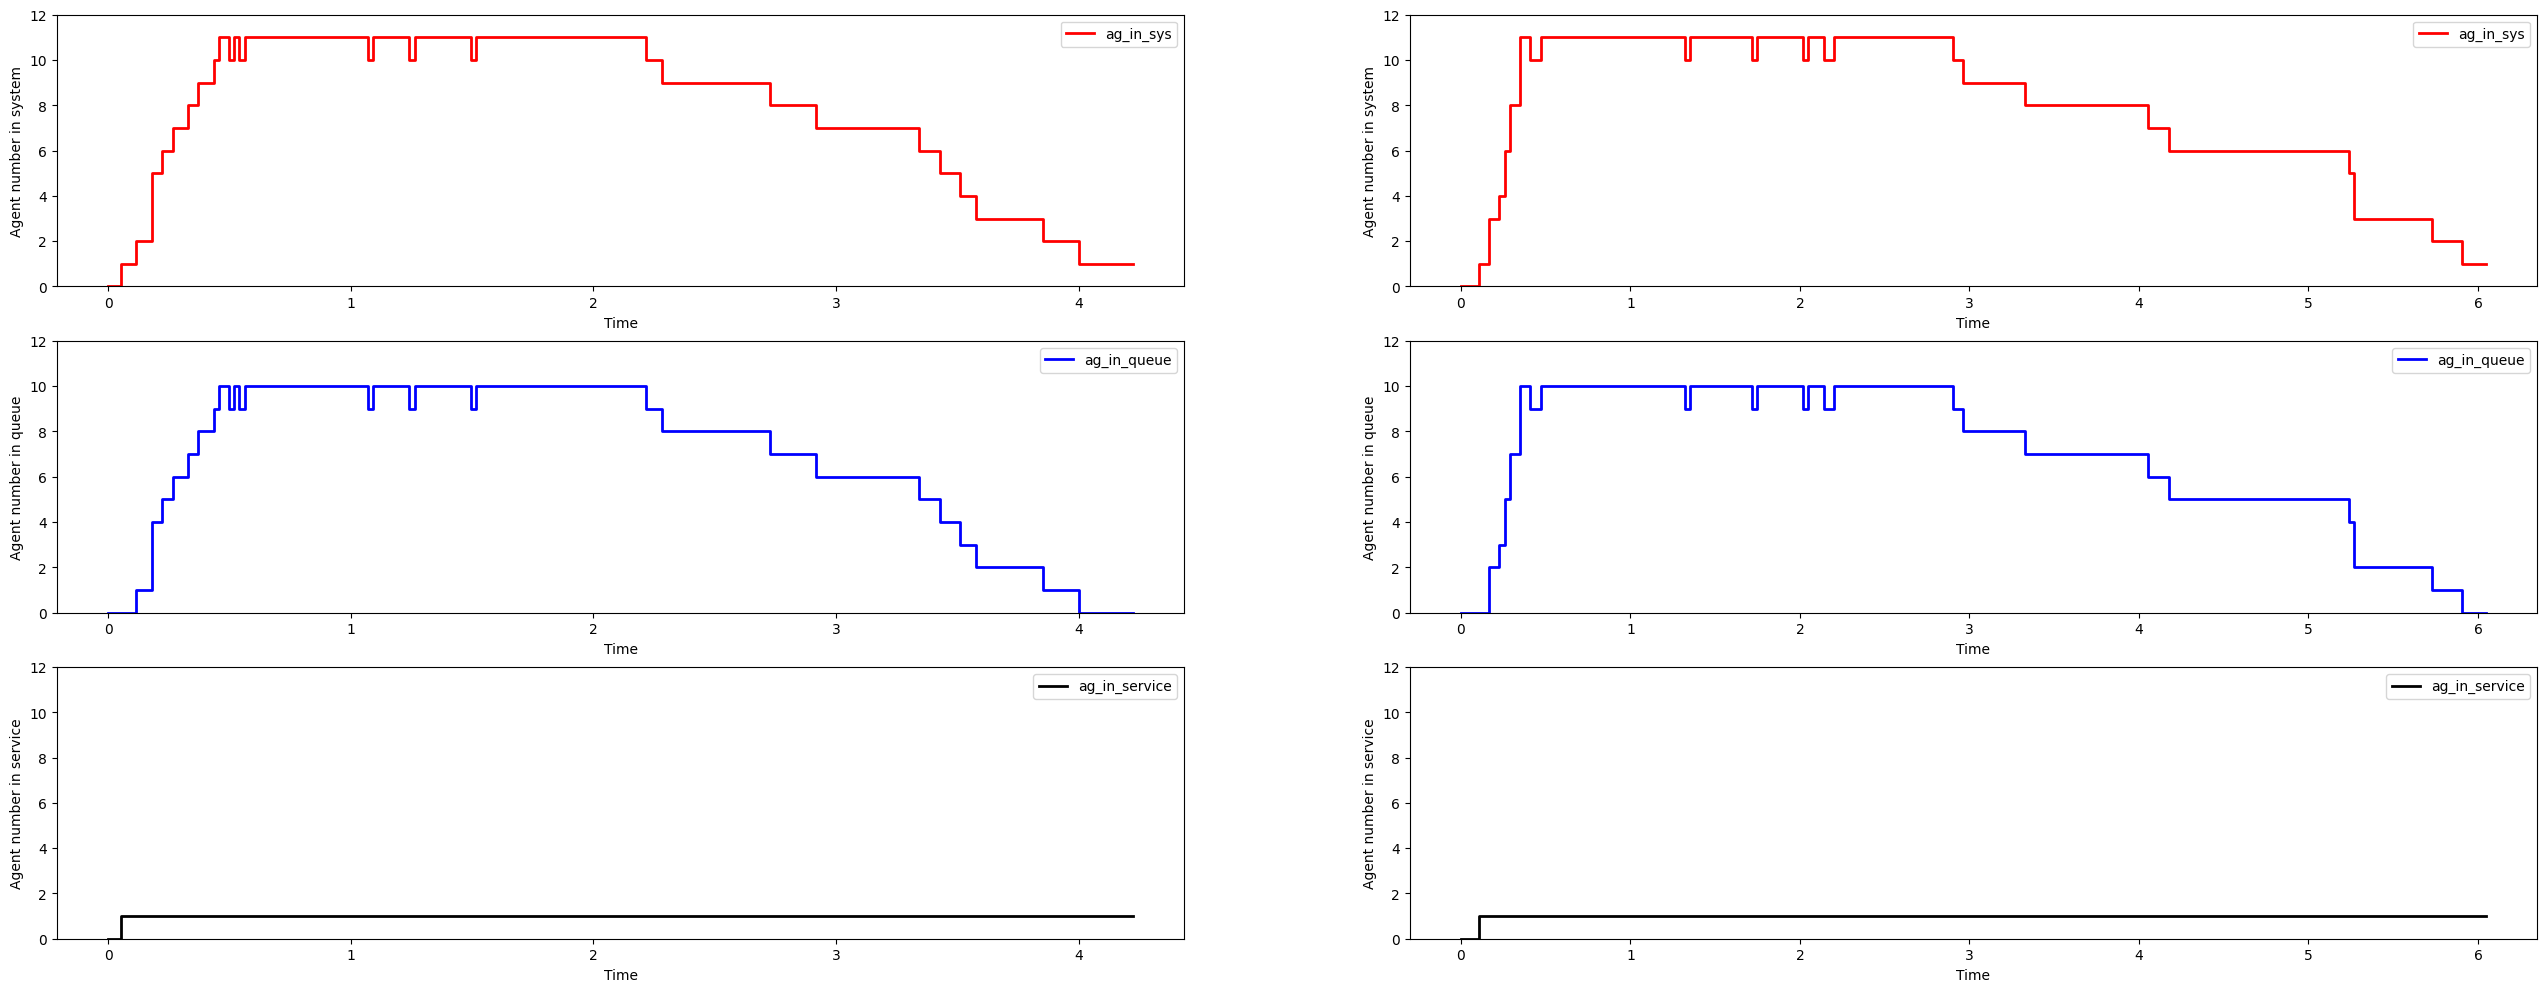

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_fifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench['ag_in_sys']+1)])
    
    mm1_lifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench['ag_in_sys']+1)])

Ici on a bouclé sur 50 simulations par ligne avec différentes valeurs pour avoir une moyenne plus représentative. 

In [16]:
# multiple evaluations with different parameters
srv_nb = 1
arval_dists = {'exp_1/40' : (lambda size : rng.exponential(1./40, size=size)), "exp_1/80" : (lambda size : rng.exponential(1./80, size=size))}
srv_dists = {'exp_1/4' : (lambda :  rng.exponential(1./4.))}#, "exp_1/0.5" : (lambda :  rng.exponential(1./0.5))}
fifo_policy = lambda x : 0
lifo_policy = lambda x : (-1)

queue_sizes = [5, 10, 100]
test_size=100

cols = ['arval_dist', 'srv_dist', 'queue_size', 'policy', 'mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 'blocked_proportion', 
         'max_waiting_time', 'q1_waiting_time', 'q3_waiting_time', 'var_waiting_time']

cols_without_names = cols[4:]

results = pd.DataFrame(np.empty((len(arval_dists)*len(srv_dists)*len(queue_sizes)*2, len(cols)),dtype=object),
                          columns=cols)

i = 0
nb_runs = 50
for arval_name, arval_dist in arval_dists.items():
    for srv_name, srv_dist in srv_dists.items():
        for queue_size in queue_sizes:
            # run n times for each configuration
            
            mean_df_fifo = pd.DataFrame(np.empty((nb_runs, len(cols)),dtype=object),
                            columns=cols)

            mean_df_lifo = pd.DataFrame(np.empty((nb_runs, len(cols)),dtype=object),
                            columns=cols)

            for j in range(0, nb_runs):
                mm1_fifo = QS(arval_dist, srv_dist, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
                mm1_lifo = QS(arval_dist, srv_dist, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)

                mm1_fifo.pretreat()
                mm1_lifo.pretreat()
                
                mm1_fifo.run()
                mm1_lifo.run()
                
                mm1_fifo.posttreat()
                mm1_lifo.posttreat()
                
                mm1_fifo_stats = mm1_fifo.timeline()[1]
                mm1_lifo_stats = mm1_lifo.timeline()[1]
                
                mean_df_fifo.loc[j, 'arval_dist'] = arval_name
                mean_df_fifo.loc[j, 'srv_dist'] = srv_name
                mean_df_fifo.loc[j, 'queue_size'] = queue_size
                mean_df_fifo.loc[j, 'policy'] = "FIFO"
                for col in cols_without_names:
                    mean_df_fifo.loc[j, col] = mm1_fifo_stats.loc[col, 'run value']
                
                mean_df_lifo.loc[j, 'arval_dist'] = arval_name
                mean_df_lifo.loc[j, 'srv_dist'] = srv_name
                mean_df_lifo.loc[j, 'queue_size'] = queue_size
                mean_df_lifo.loc[j, 'policy'] = "LIFO"
                for col in cols_without_names:
                    mean_df_lifo.loc[j, col] = mm1_lifo_stats.loc[col, 'run value']

            # compute mean of the n runs
            mean_df_fifo = mean_df_fifo.groupby(['arval_dist', 'srv_dist', 'queue_size', 'policy']).mean().reset_index()
            mean_df_lifo = mean_df_lifo.groupby(['arval_dist', 'srv_dist', 'queue_size', 'policy']).mean().reset_index()

            # add to results
            results.loc[i, 'arval_dist'] = arval_name
            results.loc[i, 'srv_dist'] = srv_name
            results.loc[i, 'queue_size'] = queue_size
            results.loc[i, 'policy'] = "FIFO"
            for col in cols_without_names:
                results.loc[i, col] = mean_df_fifo.loc[0, col]

            results.loc[i+1, 'arval_dist'] = arval_name
            results.loc[i+1, 'srv_dist'] = srv_name
            results.loc[i+1, 'queue_size'] = queue_size
            results.loc[i+1, 'policy'] = "LIFO"
            for col in cols_without_names:
                results.loc[i+1, col] = mean_df_lifo.loc[0, col]

            i = i + 2

results

,arval_dist,srv_dist,queue_size,policy,mean_sojourn_time,mean_waiting_time,mean_service_time,blocked_proportion,max_waiting_time,q1_waiting_time,q3_waiting_time,var_waiting_time
0,exp_1/40,exp_1/4,5,FIFO,1.280069,1.014996,0.265073,0.8456,2.009008,0.591403,1.480882,0.443276
1,exp_1/40,exp_1/4,5,LIFO,1.216467,0.960118,0.256348,0.8318,2.015873,0.62675,1.467839,0.432608
2,exp_1/40,exp_1/4,10,FIFO,2.060971,1.802529,0.258442,0.794,3.212863,0.990689,2.659442,1.216279
3,exp_1/40,exp_1/4,10,LIFO,1.989669,1.737442,0.252227,0.7812,3.408852,0.951695,2.708605,1.324032
4,exp_1/40,exp_1/4,100,FIFO,11.321473,11.07054,0.250933,0.0,22.399571,5.600515,16.746809,43.20184
5,exp_1/40,exp_1/4,100,LIFO,10.894492,10.648334,0.246157,0.0,21.919113,5.35505,16.331095,42.464133
6,exp_1/80,exp_1/4,5,FIFO,1.173078,0.9109,0.262178,0.8934,1.630703,0.532775,1.347805,0.376818
7,exp_1/80,exp_1/4,5,LIFO,1.144783,0.891615,0.253168,0.8916,1.788509,0.58295,1.443094,0.438636
8,exp_1/80,exp_1/4,10,FIFO,1.793899,1.548151,0.245748,0.8368,2.808072,0.88877,2.28344,0.940892
9,exp_1/80,exp_1/4,10,LIFO,1.770033,1.527079,0.242954,0.8282,3.011759,0.843987,2.453124,1.124987


In [17]:
# change the values of the dataframe to numeric
results[cols_without_names] = results[cols_without_names].apply(pd.to_numeric)
results.dtypes

arval_dist             object
srv_dist               object
queue_size             object
policy                 object
mean_sojourn_time     float64
mean_waiting_time     float64
mean_service_time     float64
blocked_proportion    float64
max_waiting_time      float64
q1_waiting_time       float64
q3_waiting_time       float64
var_waiting_time      float64
dtype: object

In [18]:
results_fifo = results[results['policy'] == "FIFO"].reset_index()
results_lifo = results[results['policy'] == "LIFO"].reset_index()

results_diff = results_fifo.copy()
results_diff[cols_without_names] = results_fifo[cols_without_names] - results_lifo[cols_without_names]
results_diff.drop(columns=['index', 'policy', 'q1_waiting_time', 'q3_waiting_time', 'var_waiting_time'], inplace=True)
results_diff

,arval_dist,srv_dist,queue_size,mean_sojourn_time,mean_waiting_time,mean_service_time,blocked_proportion,max_waiting_time
0,exp_1/40,exp_1/4,5,0.063603,0.054877,0.008725,0.0138,-0.006865
1,exp_1/40,exp_1/4,10,0.071302,0.065087,0.006215,0.0128,-0.195989
2,exp_1/40,exp_1/4,100,0.426981,0.422206,0.004775,0.0000,0.480458
3,exp_1/80,exp_1/4,5,0.028295,0.019285,0.009010,0.0018,-0.157807
4,exp_1/80,exp_1/4,10,0.023866,0.021072,0.002794,0.0086,-0.203687
5,exp_1/80,exp_1/4,100,0.357283,0.352585,0.004698,0.0000,0.399648


### Question 1.1
Pour les taux d'arrivée et de service donnés, la méthode FIFO tend à donner des temps de séjour et d'attente moyens plus longs par rapport à la méthode LIFO, peu importe la taille de la file d'attente. Cependant, la méthode FIFO semble réduire le temps d'attente maximal, ce qui peut être bénéfique pour éviter des temps d'attente extrêmement longs pour certains clients. 

Plus de client sont bloqués dans le cas de la méthode FIFO que dans le cas de la méthode LIFO.

### Question 1.2
Lorsque la queue fait la taille de la pop (100) les conclusion ne changent pas pour le temps d'attente moyen et le temps de séjour moyen. Cependant, le temps d'attente maximal est plus long pour la méthode FIFO que pour la méthode LIFO dorénavant.

# Question 2

On suppose avoir à diposition $5$ serveurs $s_1$, $\ldots$, $s_5$ et $3$ files d'arrivées *FIFO* $f_1$, $f_1$, $f_3$ de tailles respectives $z_1$, $z_2$, $z_3$. Les temps de services de nos serveurs sont respectivements donnés par des lois exponentielles paramètres $\mu_1$, $\ldots$, $\mu_5$, ordonnés par ordre croissant.  

Une population d'agents s'adresse à notre service, déployé identitiquement sur chaque serveur. On constate que cette population est décomposée en $5$ sous-populations $A_1$, $\ldots$, $A_5$ dont les processus d'arrivées sont respectivement d'intensités $\lambda_1$, $\ldots$, $\lambda_5$, ordonnés par ordre croissants. Les tailles respectives de chacune des populations sont $a_1$, $\ldots$, $a_5$ ; elles vérifient les relations $a_i > 2\max\{z_1, z_2, z_3\}$ pour tout $1 \leq i \leq 5$.   

1. Simuler un système d'attente qui permet de répondre aux besoins de services.
2. Comparer un minimum de trois architectures possibles, au regard des ressources à disposition, pour répondre aux besoins de services. Vous êtes attendus sur des simulations appuyants vos propos.
3. Quelles modifications apporteriez-vous sur votre proposition si l'on introduit une fonction de dissatisfaction des agents donnée par $ b_1 + 2 b_2 + \cdots 5 b_5$, où $b_i$ correspond au nombre d'agents de la populations $A_i$ qui n'ont pas pu avoir accès au système ?

Vous êtes autorisé d'effectuer des hypothèses simplificatrices dans votre travail. Attention à ce qu'elles ne soient pas *trop* simplificatrices.

N.B: Les populations ne sont indexées sur aucune file d'attente en particulier. Tout l'enjeu est d'exprimer une solution qui nous permet de varier nos stratégies: Quelles population est envoyé sur quelle file d'attente, avec quel serveur derrière et comment ?

### Question 1

Initialisation des valeurs:

In [55]:
rng = np.random.default_rng(seed=42)

srv_nb = 5

z1 = 10
z2 = 20
z3 = 30

mu1 = 0.1
mu2 = 0.4
mu3 = 1
mu4 = 2
mu5 = 4

A1 = 100
A2 = 250
A3 = 500
A4 = 1000
A5 = 2000

lb1 = 0.5
lb2 = 1
lb3 = 5
lb4 = 20
lb5 = 40

arv_dists = [lambda : rng.exponential(1./lb1, size=A1),
             lambda : rng.exponential(1./lb2, size=A2),
             lambda : rng.exponential(1./lb3, size=A3),
             lambda : rng.exponential(1./lb4, size=A4),
             lambda : rng.exponential(1./lb5, size=A5)]

srv_dists = [lambda : rng.exponential(1./mu1),
             lambda : rng.exponential(1./mu2),
             lambda : rng.exponential(1./mu3),
             lambda : rng.exponential(1./mu4),
             lambda : rng.exponential(1./mu5)]


1.  Simulation système d'attente, pour cela il nous faut réécrire la classe QS:

Implémentons une architecture flexible, c'est-à-dire que les agents sont dirigés vers n'importe quelle serveurs en fonction de leur disponibilité.

In [56]:
class QS():
    def __init__(self, arval_dists, srv_dists, servers_nb, test_size, queue_sizes, policy=lambda x: 0):
        self.arval_dists = arval_dists
        self.srv_dists = srv_dists
        self.srv_nb = servers_nb
        self.queue_sizes = queue_sizes
        self.test_size = test_size

        self.wlines = [Wline(size=q_size, policy=policy) for q_size in self.queue_sizes]
        self.inservice = InService(nb=servers_nb, dist=srv_dists)

        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3), dtype=object), columns=column_names)

    def pretreat(self):
        tops = self.tops

        t_interarvals =  []

        for arval_dist in self.arval_dists:
            t_interarvals.append(arval_dist())

        t_interarvals = np.concatenate(t_interarvals)
        np.random.shuffle(t_interarvals)
        tops.loc[0, f't_arval_queue'] = t_interarvals[0]

        for agent in range(1, len(t_interarvals)):
            tops.loc[agent, f't_arval_queue'] = tops.loc[agent-1, f't_arval_queue'] + t_interarvals[agent]
        
            
    def run(self):
        wlines = self.wlines
        inservice = self.inservice
        tops = self.tops


        wlines[0].queue = [0]
        wlines[1].queue = [1]
        wlines[2].queue = [2]
        buffer_ix = 1

        while buffer_ix < self.test_size:
            for i, wline in enumerate(wlines):
                _next = wline.pop()
                if _next is not None:  # Waiting line is not empty
                    tops.loc[_next, f't_arval_srv'] = tops.loc[_next, f't_arval_queue']  # Update server arrival time

                    srv_ix, dept_ag = inservice.leaving(tops)  # Find next available server
                    inservice.server[srv_ix] = _next  # Fill available server with corresponding next agent in waiting line

                    if dept_ag is not None and tops.loc[_next, f't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                        tops.loc[_next, f't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']  # Update server arrival time if arrival is before system departure

                    tops.loc[_next, 't_depart_sys'] = tops.loc[_next, f't_arval_srv'] + inservice.dist[srv_ix]()  # Update system departure time

                in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, f't_arval_queue']).sum()  # Counting prior agents still in system

                if self.queue_sizes[i] is not None and in_system >= self.queue_sizes[i] + self.inservice.nb:
                    tops.loc[buffer_ix, 't_depart_sys'] = -1
                else:
                    wline.queue.append(buffer_ix)

                buffer_ix += 1

    def posttreat(self):
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 

    def timeline(self, t_delation=2):
        #Easing naming
        tops = self.tops
        test_z = self.test_size

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage',
                    'max_waiting_time', 'q1_waiting_time', 'q3_waiting_time', 'var_waiting_time']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        tops_without_blocked = tops.loc[~tops['blocked']]
        stats.loc['max_waiting_time'] = tops_without_blocked['t_waiting'].max()
        stats.loc['q1_waiting_time'] = tops_without_blocked['t_waiting'].quantile(0.25)
        stats.loc['q3_waiting_time'] = tops_without_blocked['t_waiting'].quantile(0.75)
        stats.loc['var_waiting_time'] = tops_without_blocked['t_waiting'].var()

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)

        return process, stats


Simulons notre service de files:

In [57]:
queues = QS(arv_dists, srv_dists, srv_nb, A1 + A2 + A3 + A4 + A5, [z1, z2, z3])

queues.pretreat()
queues.run()
queues.posttreat()
timeline, stats = queues.timeline()

print("Timeline:")
print(timeline)
print("\nStatistics:")
print(stats)

Timeline:
           ag_in_sys ag_in_queue ag_in_service
0.000000           0           0             0
0.083329           0           0             0
0.166658           0           0             0
0.249986           0           0             0
0.333315           0           0             0
...              ...         ...           ...
641.215021         1           0             1
641.298350         1           0             1
641.381679         1           0             1
641.465007         1           0             1
641.548336         1           0             1

[7700 rows x 3 columns]

Statistics:
                   run value
mean_sojourn_time   1.697366
mean_waiting_time   0.966995
mean_service_time   0.730371
waiting_proportion  0.805597
blocked_proportion  0.127532
servers_max_usage   0.592415
max_waiting_time    4.618025
q1_waiting_time     0.114253
q3_waiting_time     1.628111
var_waiting_time    0.909617


Présentons la timeline d'occupation des agents:

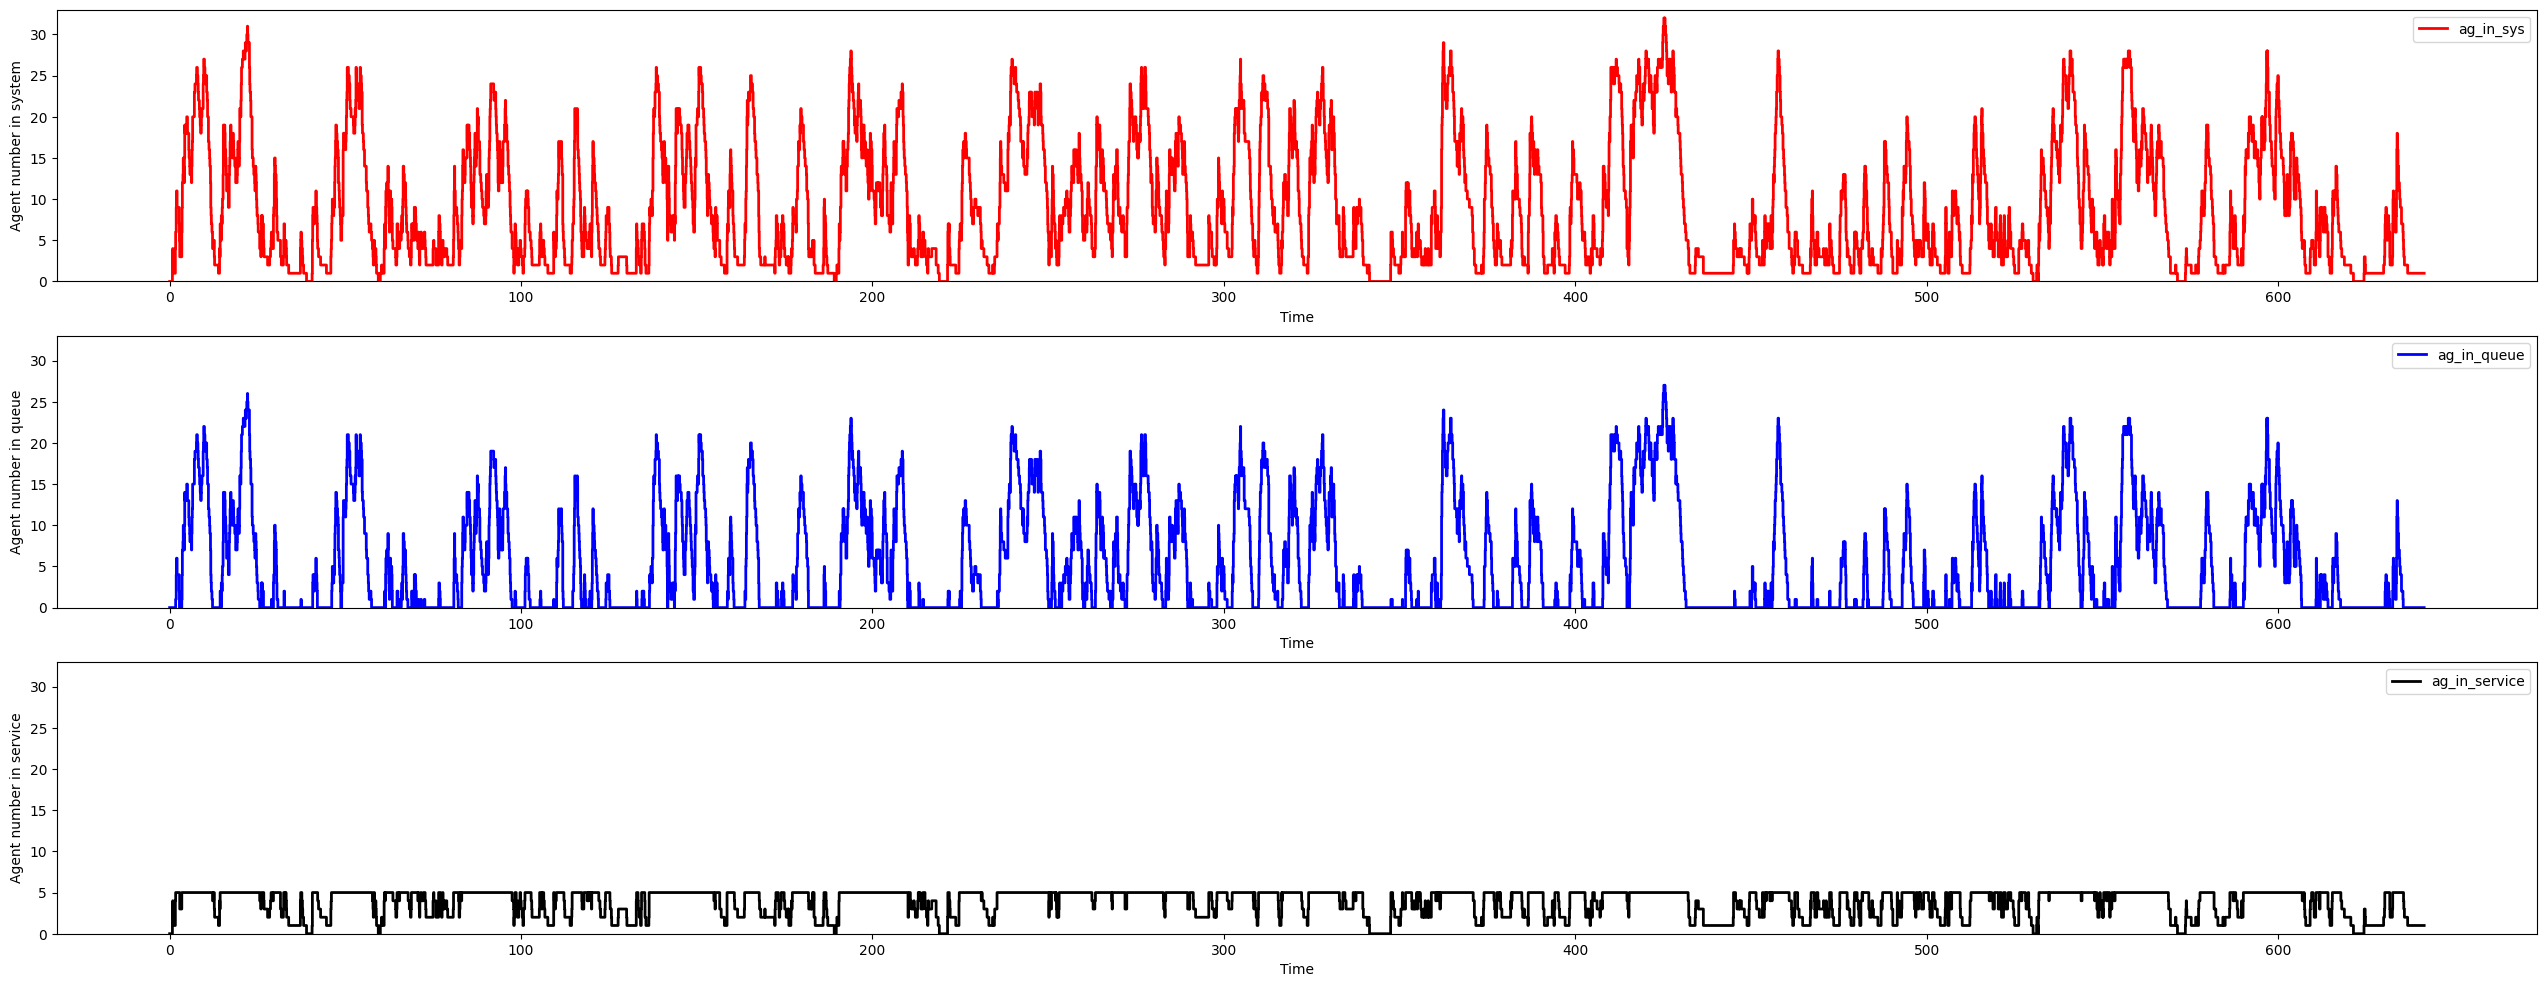

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline.plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['ag_in_sys']+1)])

2. Comparer un minimum de trois architectures possibles, au regard des ressources à disposition, pour répondre aux besoins de services. Vous êtes attendus sur des simulations appuyants vos propos.

Implémentons une parallel queue (chaque file d'arrivée est associée à un serveur spécifique)

In [63]:
# Voici une architecture simple où chaque serveur est associé à une seule file d'attente et ne change pas.
# C'est une version simplifiée de la simulation que vous avez partagée précédemment.

class ParralelQS(QS):
    def __init__(self, arval_dists, srv_dists, servers_nb, test_size, queue_sizes):
        super().__init__(arval_dists, srv_dists, servers_nb, test_size, queue_sizes)

    def run(self):
        tops = self.tops

        # Assignation initiale des agents à des files d'attente
        for i in range(0, len(self.wlines)):
            self.wlines[i].queue = [i]

        buffer_ix = len(self.wlines)  # Commence à enregistrer les nouveaux agents après l'assignation initiale

        while buffer_ix < self.test_size:
            # Récupérer l'index de la file d'attente avec le moins d'agents
            min_ix = np.argmin([len(wline.queue) for wline in self.wlines])

            # Récupérer le prochain agent de la file d'attente
            _next = self.wlines[min_ix].pop()

            if _next is not None:
                # Mise à jour du temps d'arrivée au serveur
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

                # Trouver le prochain serveur disponible
                srv_ix, dept_ag = self.inservice.leaving(tops)

                # Mettre l'agent dans le serveur disponible
                self.inservice.server[srv_ix] = _next

                if dept_ag is not None and tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                    tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

                # Mise à jour du temps de départ du système
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + self.inservice.dist[srv_ix]()

            # Compter le nombre d'agents encore dans le système
            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, 't_arval_queue']).sum()

            # Si le système est plein, marquer l'agent comme bloqué
            if self.queue_sizes[min_ix] is not None and in_system >= self.queue_sizes[min_ix] + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            else:
                # Sinon, ajouter l'agent à la file d'attente
                self.wlines[min_ix].queue.append(buffer_ix)

            # Passer à l'agent suivant
            buffer_ix += 1

parralel_queues = ParralelQS(arv_dists, srv_dists, srv_nb, A1 + A2 + A3 + A4 + A5, [z1, z2, z3])

parralel_queues.pretreat()
parralel_queues.run()
parralel_queues.posttreat()
parralel_timeline, parralel_stats = parralel_queues.timeline()

print("Timeline for Parralel Architecture:")
print(parralel_timeline)
print("\nStatistics for Parralel Architecture:")
print(parralel_stats)


Timeline for Parralel Architecture:
           ag_in_sys ag_in_queue ag_in_service
0.000000           0           0             0
0.089101           1           0             1
0.178201           1           0             1
0.267302           1           0             1
0.356403           3           0             3
...              ...         ...           ...
685.629513         1           0             1
685.718613         1           0             1
685.807714         1           0             1
685.896815         1           0             1
685.985915         1           0             1

[7700 rows x 3 columns]

Statistics for Parralel Architecture:
                   run value
mean_sojourn_time   1.328261
mean_waiting_time   0.548646
mean_service_time   0.779615
waiting_proportion  0.757837
blocked_proportion  0.188052
servers_max_usage    0.50539
max_waiting_time    3.050445
q1_waiting_time     0.019948
q3_waiting_time     0.914234
var_waiting_time    0.286028


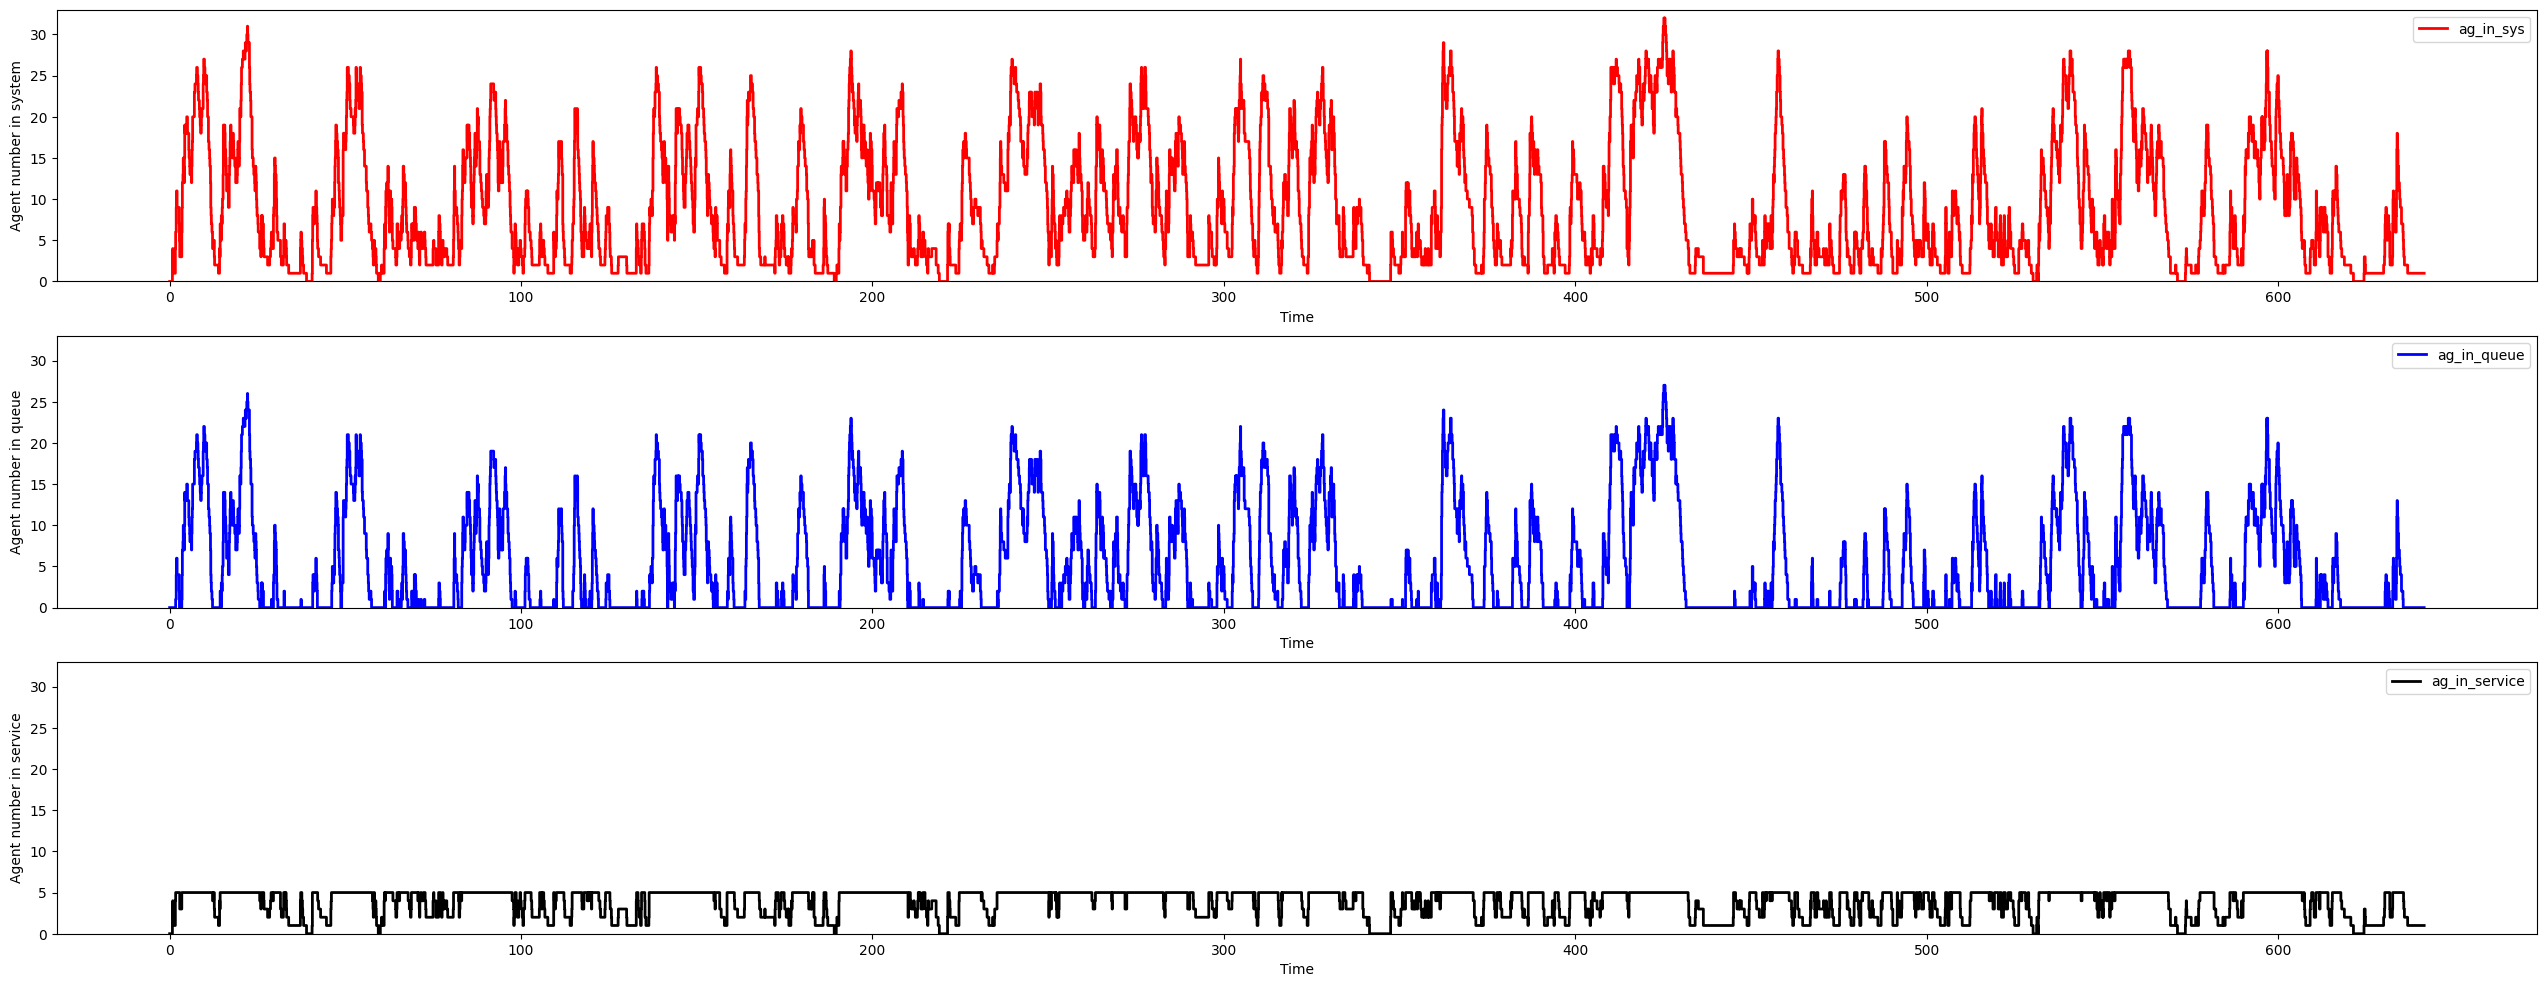

In [64]:
fig, axes = plt.subplots(3, 1, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline.plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['ag_in_sys']+1)])

Implémentons une Round Robin queue service (les agents des différentes files d'arrivées sont servis en alternance de manière équitable)

In [67]:
class RRQS(QS):
    def __init__(self, arval_dists, srv_dists, servers_nb, test_size, queue_sizes, policy=lambda x: 0):
        super().__init__(arval_dists, srv_dists, servers_nb, test_size, queue_sizes, policy)
        self.current_queue = 0  # Current queue index for round robin

    def run(self):
        wlines = self.wlines
        inservice = self.inservice
        tops = self.tops

        wlines[0].queue = [0]
        wlines[1].queue = [1]
        wlines[2].queue = [2]
        buffer_ix = 1

        while buffer_ix < self.test_size:
            wline = wlines[self.current_queue]
            _next = wline.pop()
            if _next is not None:  # Waiting line is not empty
                tops.loc[_next, f't_arval_srv'] = tops.loc[_next, f't_arval_queue']  # Update server arrival time

                srv_ix, dept_ag = inservice.leaving(tops)  # Find next available server
                inservice.server[srv_ix] = _next  # Fill available server with corresponding next agent in waiting line

                if dept_ag is not None and tops.loc[_next, f't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                    tops.loc[_next, f't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']  # Update server arrival time if arrival is before system departure

                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, f't_arval_srv'] + inservice.dist[srv_ix]()  # Update system departure time

            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, f't_arval_queue']).sum()  # Counting prior agents still in system

            if self.queue_sizes[self.current_queue] is not None and in_system >= self.queue_sizes[self.current_queue] + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            else:
                wline.queue.append(buffer_ix)

            self.current_queue = (self.current_queue + 1) % len(self.queue_sizes)  # Round robin
            buffer_ix += 1

rr_queues = RRQS(arv_dists, srv_dists, srv_nb, A1 + A2 + A3 + A4 + A5, [z1, z2, z3])

rr_queues.pretreat()
rr_queues.run()
rr_queues.posttreat()
rr_timeline, rr_stats = rr_queues.timeline()

print("Round Robin Timeline:")
print(rr_timeline)
print("\nRound Robin Statistics:")
print(rr_stats)

Round Robin Timeline:
           ag_in_sys ag_in_queue ag_in_service
0.000000           0           0             0
0.093760           1           0             1
0.187521           1           0             1
0.281281           1           0             1
0.375041           1           0             1
...              ...         ...           ...
721.485975         1           0             1
721.579735         1           0             1
721.673496         1           0             1
721.767256         1           0             1
721.861016         1           0             1

[7700 rows x 3 columns]

Round Robin Statistics:
                   run value
mean_sojourn_time   1.687222
mean_waiting_time   0.930001
mean_service_time   0.757221
waiting_proportion  0.803307
blocked_proportion  0.104675
servers_max_usage   0.548902
max_waiting_time    4.322703
q1_waiting_time       0.1205
q3_waiting_time     1.488952
var_waiting_time    0.806476


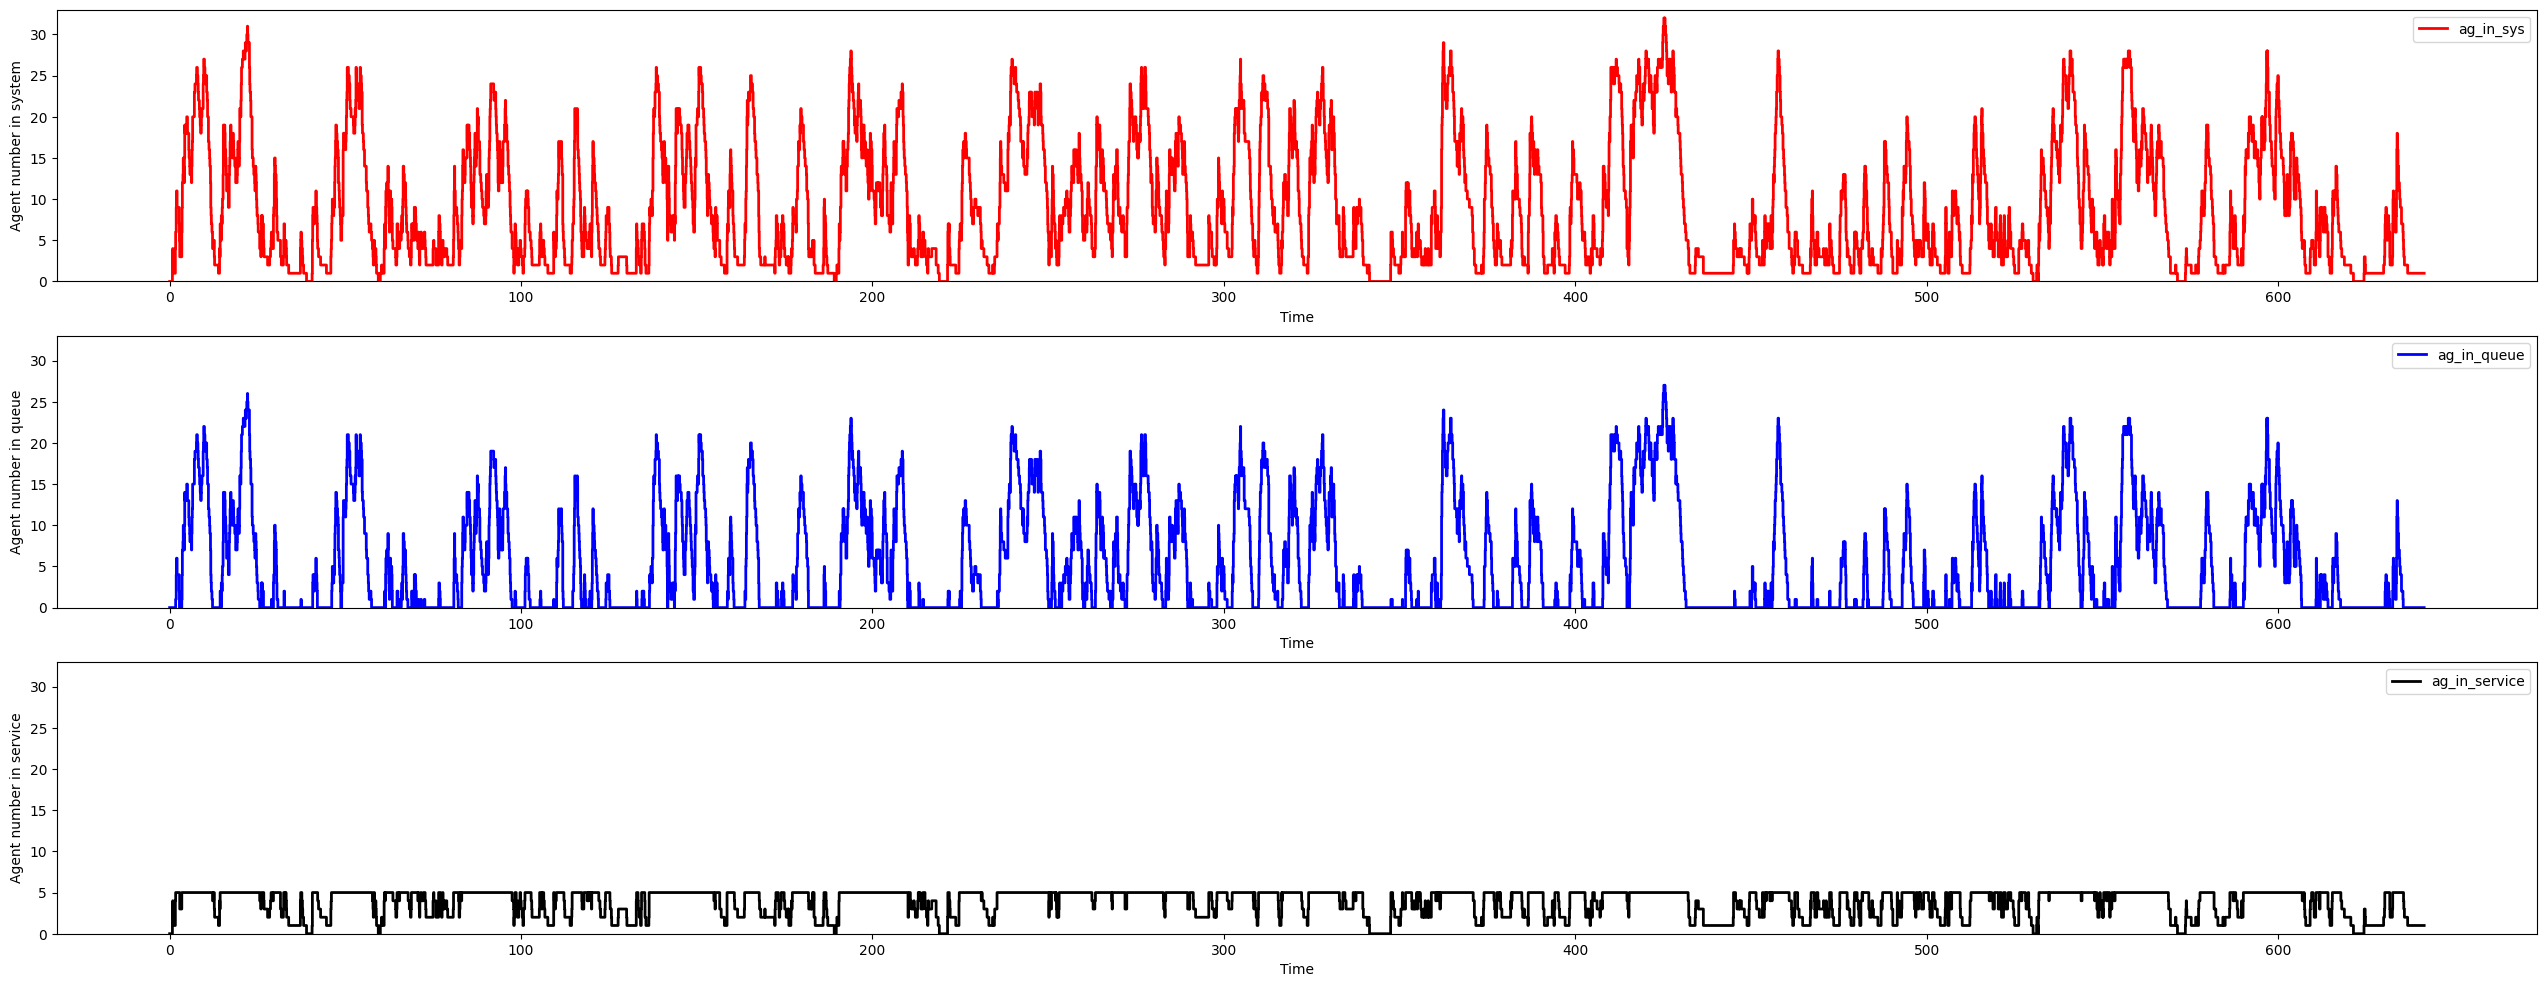

In [68]:
fig, axes = plt.subplots(3, 1, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline.plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['ag_in_sys']+1)])

### 2. Comparaison des architectures

1. **Architecture flexible:**
   - Temps d'attente moyen : 0.966995
   - Proportion bloquée : 0.127532

   L'architecture flexible a le temps d'attente moyen le plus élevé parmi les trois. Cela peut indiquer que cette architecture n'est pas aussi efficace pour réduire les temps d'attente pour les clients. La proportion bloquée est plus élevée que celle du Round Robin mais plus faible que celle de l'architecture parallèle, ce qui indique que, bien qu'elle ait une proportion de demandes bloquées plus élevée que celle du Round Robin, elle fait mieux que l'architecture parallèle à cet égard.

2. **Architecture parallèle:**
   - Temps d'attente moyen : 0.548646
   - Proportion bloquée : 0.188052

   L'architecture parallèle a un temps d'attente moyen nettement inférieur à celui du système Round Robin, ce qui suggère qu'elle peut offrir une meilleure expérience aux clients en termes de réduction des temps d'attente. Cependant, elle a une proportion bloquée plus élevée, ce qui suggère qu'une plus grande proportion de demandes ne peut pas être traitée car tous les serveurs sont occupés.

3. **Round Robin (Tourniquet):**
   - Temps d'attente moyen : 0.930001
   - Proportion bloquée : 0.104675

   L'approche Round Robin donne un temps d'attente moyen relativement élevé, ce qui suggère que les clients passent pas mal de temps à attendre. Cependant, la proportion bloquée est relativement faible, ce qui indique que les demandes sont généralement traitées au bout du compte, bien qu'elles puissent devoir attendre.


D'après ces statistiques, il semble y avoir un compromis entre le temps d'attente et la proportion bloquée. L'architecture parallèle offre les meilleures performances en termes de réduction du temps d'attente, mais au prix d'une proportion bloquée plus élevée. Inversement, l'architecture Round Robin fait un meilleur travail pour maintenir la proportion bloquée basse, mais au détriment de temps d'attente plus longs.

L'architecture flexible ne semble exceller dans aucun de ces critères par rapport aux deux autres architectures, car elle a le temps d'attente le plus élevé et une proportion bloquée qui est pire que le Round Robin mais meilleure que le parallèle.

En choisissant la meilleure architecture, le choix dépendrait de l'importance de chaque critère pour votre cas d'utilisation spécifique. Si la minimisation du temps d'attente est la plus critique, l'architecture parallèle pourrait être le meilleur choix. Si la minimisation de la proportion de demandes bloquées est plus importante, alors Round Robin pourrait être le choix le plus approprié.

### Question 3

Pour répondre a cette question il faudrait changer notre implémentation afin de pouvoir garder l'association chaque agent à sa population initiale. Ensuite, il faudrait implémenter une fonction de dissatisfaction qui prend en compte le nombre d'agents de la population $A_i$ qui n'ont pas pu avoir accès au système. 

Il est fort à parier que l'architecture parallele serait la moins efficace dans ce cas, car c'est celle avec le plus haut taux de blocage.

Néanmoins on ne peut pas conclure sans avoir fait les simulations pour Round Robin et Flexible.